In [1]:
import numpy as np
import glob
import json

from skimage import draw

import matplotlib.pyplot as plt

import os
from cv2 import cv2

from PIL import Image

import random

import tifffile as tiff

import pandas as pd

from collections import OrderedDict

import cv2
import numpy as np
# import openslide
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from tifffile import memmap

import albumentations as A

from skimage import morphology as morph

import skimage
from skimage.color import rgb2gray, rgb2hed, hed2rgb, rgb2hsv, hsv2rgb
from skimage.exposure import rescale_intensity
from skimage.util import dtype

import torch
import torch.nn.functional as F

import torchvision
from torchvision import transforms

import logging

import warnings
warnings.filterwarnings("ignore")

from SwinUnet.networks.vision_transformer import SwinUnet as ViT_seg

from scipy.ndimage import measurements
from skimage.morphology import remove_small_objects

import segmentation_models_pytorch as smp

import numpy as np
import os
import pandas as pd
from tqdm.auto import tqdm

from metrics.stats_utils import get_pq, get_multi_pq_info, get_multi_r2

from scipy.ndimage import filters, measurements
from scipy.ndimage.morphology import (
    binary_dilation,
    binary_fill_holes,
    distance_transform_cdt,
    distance_transform_edt,
)

from skimage.segmentation import watershed

import sys
sys.path.append('segmenter/')

from segmenter.segm.model.factory import create_segmenter


from my_misc import *
from my_misc import __proc_np_hv


from hover_net.run_utils.utils import (
    check_manual_seed, colored,
    convert_pytorch_checkpoint
)


import torch.cuda.amp as amp  
scaler = amp.GradScaler()


from hover_net.models.hovernet.net_desc import HoVerNetExt

In [2]:
def process_segmentation_original(np_map, hv_map, tp_map):
    # HoVerNet post-proc is coded at 0.25mpp so we resize
    np_map = cv2.resize(np_map, (0, 0), fx=2.0, fy=2.0)
    hv_map = cv2.resize(hv_map, (0, 0), fx=2.0, fy=2.0)
    tp_map = cv2.resize(
                    tp_map, (0, 0), fx=2.0, fy=2.0,
                    interpolation=cv2.INTER_NEAREST)

    inst_map = __proc_np_hv(np_map[..., None], hv_map)
    inst_dict = get_instance_info(inst_map, tp_map)

    # Generating results match with the evaluation protocol
    type_map = np.zeros_like(inst_map)
    inst_type_colours = np.array([
        [v['type']] * 3 for v in inst_dict.values()
    ])
    type_map = overlay_prediction_contours(
        type_map, inst_dict,
        line_thickness=-1,
        inst_colours=inst_type_colours)

    pred_map = np.dstack([inst_map, type_map])
    # The result for evaluation is at 0.5mpp so we scale back
    pred_map = cv2.resize(
                    pred_map, (0, 0), fx=0.5, fy=0.5,
                    interpolation=cv2.INTER_NEAREST)
    return pred_map

def process_segmentation(output_binary, output_hv, output_classification):

    np_map = torch.softmax(output_binary, 1)[0].cpu().detach().permute(1, 2, 0)[..., 1].unsqueeze(2).numpy()
    np_map = cv2.resize(np_map.astype('float32'), (0, 0), fx=2.0, fy=2.0)

    hv_map = output_hv[0].cpu().detach().permute(1, 2, 0).numpy().astype('float32')
    hv_map = cv2.resize(hv_map, (0, 0), fx=2.0, fy=2.0) 

    tp_map = torch.argmax(torch.softmax(output_classification, 1), 1).cpu().numpy()[0]
    tp_map = cv2.resize(tp_map, (0, 0), fx=2.0, fy=2.0, interpolation=cv2.INTER_NEAREST).astype('float32')

    inst_map = __proc_np_hv(np_map[..., None], hv_map)
    inst_dict = get_instance_info(inst_map, tp_map)

    type_map = np.zeros_like(inst_map)
    inst_type_colours = np.array([
        [v['type']] * 3 for v in inst_dict.values()
    ])
    type_map = overlay_prediction_contours(
        type_map, inst_dict,
        line_thickness=-1,
        inst_colours=inst_type_colours)

    pred_map = np.dstack([inst_map, type_map])

    pred_map = cv2.resize(pred_map, (0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_NEAREST)
    
    return pred_map





def process_segmentation_2branch(output_binary, output_classification):

    tp_map = torch.argmax(torch.softmax(output_classification, 1), 1).cpu().numpy()[0]

    temp = torch.argmax(torch.softmax(output_binary, 1), 1).cpu()[0]
    inst_map = measurements.label(temp)[0]
    inst_map = remove_small_objects(inst_map, 10)
    
    inst_dict = get_instance_info(inst_map, tp_map)

    type_map = np.zeros_like(inst_map)
    inst_type_colours = np.array([
        [v['type']] * 3 for v in inst_dict.values()
    ])
    type_map = overlay_prediction_contours(
        type_map, inst_dict,
        line_thickness=-1,
        inst_colours=inst_type_colours)

    pred_map = np.dstack([inst_map, type_map])

    
    return pred_map




class ConicDataset(Dataset):

    def __init__(self, image_path, mask_path, counts, source, transform, copypaste, copy_level):

        self.image_path = image_path
        self.mask_path = mask_path
        self.counts = counts
        self.source = source

        self.transform = transform
        self.copypaste = copypaste
        self.copy_level = copy_level
        
        
        with open('insufficient_class_alldict/insufficient_class_alldict.pickle','rb') as temp:
            self.insufficient_class_alldict = pickle.load(temp)  
        
        with open('insufficient_class_alldict/insufficient_class_alldict_consep.pickle','rb') as temp:
            self.insufficient_class_alldict_consep = pickle.load(temp)      
            
        with open('insufficient_class_alldict/insufficient_class_alldict_crag.pickle','rb') as temp:
            self.insufficient_class_alldict_crag = pickle.load(temp) 
            
        with open('insufficient_class_alldict/insufficient_class_alldict_dpath.pickle','rb') as temp:
            self.insufficient_class_alldict_dpath = pickle.load(temp) 
            
        with open('insufficient_class_alldict/insufficient_class_alldict_glas.pickle','rb') as temp:
            self.insufficient_class_alldict_glas = pickle.load(temp)       
            
        with open('insufficient_class_alldict/insufficient_class_alldict_pannuke.pickle','rb') as temp:
            self.insufficient_class_alldict_pannuke = pickle.load(temp)             
            
   

    def __len__(self):
        return (len(self.image_path))

    def __getitem__(self, idx):

        image = self.image_path[idx].astype('uint8')
        original = image.copy()

        mask = self.mask_path[idx]
        
        mask_instance = mask[..., 0]
        mask_class = mask[..., 1]
        
        counts = self.counts[idx]
        source = self.source[idx]
        
        
        class1_copy_num = np.random.randint(24)
        class2_copy_num = np.random.randint(6)
        class3_copy_num = np.random.randint(11)
        class4_copy_num = np.random.randint(12)
        class5_copy_num = np.random.randint(24)
        class6_copy_num = np.random.randint(11)
        resize_rate = 1
        
        
        if self.copypaste:
            
            if self.copy_level == 'random':
                dict_ = self.insufficient_class_alldict
                
                if random.random() > 0.5:
                    
                    print('Copy Paste !')
                    
                    copypaste_result = copypaste_random_instance(image, mask_instance, mask_class, 
                                                                 class1_copy_num, class2_copy_num, class3_copy_num, 
                                                                 class4_copy_num, class5_copy_num, class6_copy_num, dict_, resize_rate)

                    image = copypaste_result['pasted_image']
                    mask_instance = copypaste_result['pasted_mask_instance']
                    mask_class = copypaste_result['pasted_mask_class']
              
            
            elif self.copy_level == 'source':
                
                if source == 'consep':
                    dict_ = self.insufficient_class_alldict_consep
                    
                if source == 'crag':
                    dict_ = self.insufficient_class_alldict_crag            
                    
                if source == 'dpath':
                    dict_ = self.insufficient_class_alldict_dpath          
                    
                if source == 'glas':
                    dict_ = self.insufficient_class_alldict_glas
                    
                if source == 'pannuke':
                    dict_ = self.insufficient_class_alldict_pannuke                    
                
                if random.random() > 0.5:
                    
                    print('Copy Paste !')
                    
                    copypaste_result = copypaste_random_instance(image, mask_instance, mask_class, 
                                                                 class1_copy_num, class2_copy_num, class3_copy_num, 
                                                                 class4_copy_num, class5_copy_num, class6_copy_num, dict_, resize_rate)

                    image = copypaste_result['pasted_image']
                    mask_instance = copypaste_result['pasted_mask_instance']
                    mask_class = copypaste_result['pasted_mask_class']
                    
            else:
                pass
                    
                    
                    
                    
                                      
                        
        if self.transform:
            

            image = A.OneOf([
                             A.GaussianBlur(blur_limit=(1, 3), p=1),
                             A.MedianBlur(blur_limit=3, p=1),
                             A.GaussNoise (var_limit=(10.0, 50.0), p=1)
                             ], p=0.5)(image=image)['image']
            
            image = A.ColorJitter(brightness=0.3, contrast=0.6, saturation=0.2, hue=0.2, p=0.5)(image=image)['image']
            
            output = A.Compose([
                #A.ShiftScaleRotate(p=1),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.Cutout(num_holes=4, max_h_size=40, max_w_size=40, p=0.5),
                A.RandomRotate90(90, p=0.5)],
                additional_targets={'mask1' : 'image',
                                    'mask2' : 'image'})(image=image.astype('uint8'), 
                                                        mask1=mask_class.astype('uint8'),
                                                        mask2=mask_instance.astype('uint8'))            
            
            
            
            image = output['image']
            mask = output['mask1']
            mask_instance = output['mask2']            
            
            
            hv_map = gen_targets(mask_instance, (256, 256))['hv_map']


            image = transforms.ToTensor()(image)
            #image = cropping_center_torch(image, crop_shape=(224, 224), batch=False)
            
            mask = torch.from_numpy(mask).unsqueeze(0)
            mask_instance = torch.from_numpy(mask_instance).unsqueeze(0)
            #mask = cropping_center_torch(mask, crop_shape=(224, 224), batch=False)
            
            hv_map = transforms.ToTensor()(hv_map)
            #hv_map = cropping_center_torch(hv_map, crop_shape=(224, 224), batch=False)
        
        
    
            return {"original" : original, "image": image, "mask": mask, "mask_instance" : mask_instance, 'hv_map' : hv_map, "counts" : counts, "source" : source}

        

        else:

            image_hflip = A.HorizontalFlip(p=1)(image=image)['image']
            image_hflip = transforms.ToTensor()(image_hflip)
            #image_hflip = cropping_center_torch(image_hflip, crop_shape=(224, 224), batch=False)
            
            image_vflip = A.VerticalFlip(p=1)(image=image)['image']
            image_vflip = transforms.ToTensor()(image_vflip)
            #image_vflip = cropping_center_torch(image_vflip, crop_shape=(224, 224), batch=False)
            
            image = transforms.ToTensor()(image)
            #image = cropping_center_torch(image, crop_shape=(224, 224), batch=False)
            
            mask = torch.from_numpy(mask_class).unsqueeze(0)
            #mask = cropping_center_torch(mask, crop_shape=(224, 224), batch=False)
            
            hv_map = gen_targets(mask_instance, (256, 256))['hv_map']
            hv_map = transforms.ToTensor()(hv_map)
            #hv_map = cropping_center_torch(hv_map, crop_shape=(224, 224), batch=False)
            
            return {"image": image, "mask": mask, 'hv_map' : hv_map, "image_hflip" : image_hflip, "image_vflip" : image_vflip, "counts" : counts, 'mask_instance' : mask_instance, "source" : source}  
        

        
        
        
        
        
        
        
        
        
        
        
run_info = '-'

if not os.path.exists('checkpoint/{}'.format(run_info)):
    os.mkdir('checkpoint/{}'.format(run_info))

log = logging.getLogger('staining_log')
log.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
fileHandler = logging.FileHandler('checkpoint/{}/log.txt'.format(run_info))
streamHandler = logging.StreamHandler()
fileHandler.setFormatter(formatter)
streamHandler.setFormatter(formatter)
#
log.addHandler(fileHandler)
log.addHandler(streamHandler)





import numpy as np
import glob
import json

from skimage import draw

import matplotlib.pyplot as plt

import os
from cv2 import cv2

from PIL import Image

import random

import tifffile as tiff

import pandas as pd

import cv2
import numpy as np
# import openslide
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from tifffile import memmap

import albumentations as A

from skimage import morphology as morph

import skimage
from skimage.color import rgb2gray, rgb2hed, hed2rgb, rgb2hsv, hsv2rgb
from skimage.exposure import rescale_intensity
from skimage.util import dtype

import torch
import torch.nn.functional as F

import torchvision
from torchvision import transforms

import logging

import warnings
warnings.filterwarnings("ignore")

from SwinUnet.networks.vision_transformer import SwinUnet as ViT_seg

from scipy.ndimage import measurements
from skimage.morphology import remove_small_objects

import segmentation_models_pytorch as smp

import numpy as np
import os
import pandas as pd
from tqdm.auto import tqdm

from metrics.stats_utils import get_pq, get_multi_pq_info, get_multi_r2

from scipy.ndimage import filters, measurements
from scipy.ndimage.morphology import (
    binary_dilation,
    binary_fill_holes,
    distance_transform_cdt,
    distance_transform_edt,
)

from skimage.segmentation import watershed

import sys
# sys.path.append('segmenter/')

# from segmenter.segm.model.factory import create_segmenter


from my_misc import *
from my_misc import __proc_np_hv



import paddleseg
from paddleseg.cvlibs import manager, Config

import argparse



def process_segmentation(output_binary, output_hv, output_classification):

    np_map = torch.softmax(output_binary, 1)[0].cpu().detach().permute(1, 2, 0)[..., 1].unsqueeze(2).numpy()
    np_map = cv2.resize(np_map.astype('float32'), (0, 0), fx=2.0, fy=2.0)

    hv_map = output_hv[0].cpu().detach().permute(1, 2, 0).numpy().astype('float32')
    hv_map = cv2.resize(hv_map, (0, 0), fx=2.0, fy=2.0) 

    tp_map = torch.argmax(torch.softmax(output_classification, 1), 1).cpu().numpy()[0]
    tp_map = cv2.resize(tp_map, (0, 0), fx=2.0, fy=2.0, interpolation=cv2.INTER_NEAREST).astype('float32')

    inst_map = __proc_np_hv(np_map[..., None], hv_map)
    inst_dict = get_instance_info(inst_map, tp_map)

    type_map = np.zeros_like(inst_map)
    inst_type_colours = np.array([
        [v['type']] * 3 for v in inst_dict.values()
    ])
    type_map = overlay_prediction_contours(
        type_map, inst_dict,
        line_thickness=-1,
        inst_colours=inst_type_colours)

    pred_map = np.dstack([inst_map, type_map])

    pred_map = cv2.resize(pred_map, (0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_NEAREST)
    
    return pred_map





def process_segmentation_2branch(output_binary, output_classification):

    tp_map = torch.argmax(torch.softmax(output_classification, 1), 1).cpu().numpy()[0]

    temp = torch.argmax(torch.softmax(output_binary, 1), 1).cpu()[0]
    inst_map = measurements.label(temp)[0]
    inst_map = remove_small_objects(inst_map, 10)
    
    inst_dict = get_instance_info(inst_map, tp_map)

    type_map = np.zeros_like(inst_map)
    inst_type_colours = np.array([
        [v['type']] * 3 for v in inst_dict.values()
    ])
    type_map = overlay_prediction_contours(
        type_map, inst_dict,
        line_thickness=-1,
        inst_colours=inst_type_colours)

    pred_map = np.dstack([inst_map, type_map])

    
    return pred_map



parser = argparse.ArgumentParser()
parser.add_argument('--fold', type=int, default=5)
# parser.add_argument('--copy_paste', type=str, default=True)
# parser.add_argument('--copy_level', type=str, default='random')
# parser.add_argument('--nooverlap', type=str, default=True)
args = parser.parse_args(args=[])


class ConicDataset(Dataset):

    def __init__(self, image_path, mask_path, counts, source, transform, copypaste, copy_level):

        self.image_path = image_path
        self.mask_path = mask_path
        self.counts = counts
        self.source = source

        self.transform = transform
        self.copypaste = copypaste
        self.copy_level = copy_level
        
        
        with open('insufficient_class_alldict/insufficient_class_alldict_Fold5_{}.pickle'.format(args.fold),'rb') as temp:
            self.insufficient_class_alldict = pickle.load(temp)  
        
        with open('insufficient_class_alldict/insufficient_class_alldict_consep_Fold5_{}.pickle'.format(args.fold),'rb') as temp:
            self.insufficient_class_alldict_consep = pickle.load(temp)      
            
        with open('insufficient_class_alldict/insufficient_class_alldict_crag_Fold5_{}.pickle'.format(args.fold),'rb') as temp:
            self.insufficient_class_alldict_crag = pickle.load(temp) 
            
        with open('insufficient_class_alldict/insufficient_class_alldict_dpath_Fold5_{}.pickle'.format(args.fold),'rb') as temp:
            self.insufficient_class_alldict_dpath = pickle.load(temp) 
            
        with open('insufficient_class_alldict/insufficient_class_alldict_glas_Fold5_{}.pickle'.format(args.fold),'rb') as temp:
            self.insufficient_class_alldict_glas = pickle.load(temp)       
            
        with open('insufficient_class_alldict/insufficient_class_alldict_pannuke_Fold5_{}.pickle'.format(args.fold),'rb') as temp:
            self.insufficient_class_alldict_pannuke = pickle.load(temp)             
            
   

    def __len__(self):
        return (len(self.image_path))

    def __getitem__(self, idx):

        image = self.image_path[idx].astype('uint8')
        original = image.copy()

        mask = self.mask_path[idx]
        
        mask_instance = mask[..., 0]
        mask_class = mask[..., 1]
        mask_class_original = mask_class.copy()
        
        counts = self.counts[idx]
        source = self.source[idx]
        
#         default   
        class1_rate = 0.3
        class2_rate = 0.1
        class3_rate = 0.05
        class4_rate = 0.15
        class5_rate = 0.3
        class6_rate = 0.1

#         class1_rate = 0.4
#         class2_rate = 0
#         class3_rate = 0
#         class4_rate = 0.2
#         class5_rate = 0.4
#         class6_rate = 0
        
        resize_rate = 0
        
        self.nooverlap = True
        
        
        if self.copypaste:
            
            if self.copy_level == 'random':
                dict_ = self.insufficient_class_alldict
                
                if random.random() > 0.5:
                    
                    print('Copy Paste !')
                    
                    copypaste_result = copypaste_candidate_instance(image, mask_instance, mask_class, 
                                                                 class1_rate, class2_rate, class3_rate, 
                                                                 class4_rate, class5_rate, class6_rate, dict_, 
                                                                 resize_rate, self.nooverlap)

                    image = copypaste_result['pasted_image']
                    mask_instance = copypaste_result['pasted_mask_instance']
                    mask_class = copypaste_result['pasted_mask_class']
              
            
            elif self.copy_level == 'source':
                
                if source == 'consep':
                    dict_ = self.insufficient_class_alldict_consep
                    
                if source == 'crag':
                    dict_ = self.insufficient_class_alldict_crag            
                    
                if source == 'dpath':
                    dict_ = self.insufficient_class_alldict_dpath          
                    
                if source == 'glas':
                    dict_ = self.insufficient_class_alldict_glas
                    
                if source == 'pannuke':
                    dict_ = self.insufficient_class_alldict_pannuke                    
                
                if random.random() > 0.5:
                    
                    print('Copy Paste !')
                    
                    copypaste_result = copypaste_candidate_instance(image, mask_instance, mask_class, 
                                                                 class1_rate, class2_rate, class3_rate, 
                                                                 class4_rate, class5_rate, class6_rate, dict_, 
                                                                 resize_rate, self.nooverlap)

                    image = copypaste_result['pasted_image']
                    mask_instance = copypaste_result['pasted_mask_instance']
                    mask_class = copypaste_result['pasted_mask_class']
                    
            else:
                pass
                    
                    
                    
                    
                                      
                        
        if self.transform:
            
            image = A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.2, p=0.5)(image=image)['image']

            image = A.OneOf([
                             A.GaussianBlur(blur_limit=(1, 3), p=1),
                             A.MedianBlur(blur_limit=3, p=1)
#                              A.GaussNoise (var_limit=(10.0, 50.0), p=1)
                             ], p=0.5)(image=image)['image']
            
            
            output = A.Compose([
#                 A.ShiftScaleRotate(shift_limit=0, scale_limit=0, rotate_limit=360, interpolation=0, border_mode=4, p=0.5),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
#                 A.CoarseDropout(max_holes=4, max_height=40, max_width=40, 
#                                 min_holes=2, min_height=20, min_width=20, p=0.5)],
                A.RandomRotate90(90, p=0.5)],
                additional_targets={'mask1' : 'image',
                                    'mask2' : 'image'})(image=image.astype('uint8'), 
                                                        mask1=mask_class.astype('uint8'),
                                                        mask2=mask_instance.astype('uint8'))            
            
            
            
            image = output['image']
            mask = output['mask1']
            mask_instance = output['mask2']            
            
            mask_instance = remap_label(mask_instance)
            hv_map = gen_targets(mask_instance, (256, 256))['hv_map']


            image = transforms.ToTensor()(image)
            #image = cropping_center_torch(image, crop_shape=(224, 224), batch=False)
            
            mask = torch.from_numpy(mask).unsqueeze(0)
            mask_instance = torch.from_numpy(mask_instance).unsqueeze(0)
            #mask = cropping_center_torch(mask, crop_shape=(224, 224), batch=False)
            
            hv_map = transforms.ToTensor()(hv_map)
            #hv_map = cropping_center_torch(hv_map, crop_shape=(224, 224), batch=False)
        
        
    
            return {"original" : original, "image": image, "mask": mask, "mask_instance" : mask_instance, 'hv_map' : hv_map, "counts" : counts, "source" : source, "mask_class_original" : mask_class_original}

        

        else:

            image_hflip = A.HorizontalFlip(p=1)(image=image)['image']
            image_hflip = transforms.ToTensor()(image_hflip)
            #image_hflip = cropping_center_torch(image_hflip, crop_shape=(224, 224), batch=False)
            
            image_vflip = A.VerticalFlip(p=1)(image=image)['image']
            image_vflip = transforms.ToTensor()(image_vflip)
            #image_vflip = cropping_center_torch(image_vflip, crop_shape=(224, 224), batch=False)
            
            image = transforms.ToTensor()(image)
            #image = cropping_center_torch(image, crop_shape=(224, 224), batch=False)
            
            mask = torch.from_numpy(mask_class).unsqueeze(0)
            #mask = cropping_center_torch(mask, crop_shape=(224, 224), batch=False)
            
            hv_map = gen_targets(mask_instance, (256, 256))['hv_map']
            hv_map = transforms.ToTensor()(hv_map)
            #hv_map = cropping_center_torch(hv_map, crop_shape=(224, 224), batch=False)
            
            return {"original" : original, "image": image, "mask": mask, 'hv_map' : hv_map, "image_hflip" : image_hflip, "image_vflip" : image_vflip, "counts" : counts, 'mask_instance' : mask_instance, "source" : source, "mask_class_original" : mask_class_original}  
        
        
        
        

from datetime import datetime

year = datetime.today().year
month = datetime.today().month
day = datetime.today().day  

today = str(year) + str(month) + str(day)        



gamma = 2
copy_level = 'source'
copy_paste = True


run_info = '{}_Unet++_Likebaseline_copypaste_candidate_allclass_focalloss{}_efficientnet-b7_5FOLD_Copypaste{}_{}_BaseAug_ratio0.5'.format(today, gamma, copy_paste, copy_level)


os.makedirs('checkpoint/{}'.format(run_info), exist_ok=True) 
os.makedirs('checkpoint/{}/Fold{}'.format(run_info, args.fold), exist_ok=True)   
    
log = logging.getLogger('staining_log')
log.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
fileHandler = logging.FileHandler('checkpoint/{}/Fold{}/log.txt'.format(run_info, args.fold))
streamHandler = logging.StreamHandler()
fileHandler.setFormatter(formatter)
streamHandler.setFormatter(formatter)
#
log.addHandler(fileHandler)
log.addHandler(streamHandler)







log.info("Fold : {}".format(args.fold))
log.info("Copy Paste: {}".format(copy_paste))
log.info("Copy Level: {}".format(copy_level))
log.info("Loss : {}".format("Focal 2"))







data_root = "patchdata/patchsize256stride256" #! Change this according to the root path where the data is located
#data_root = "data"

images_path = "%s/images.npy" % data_root # images array Nx256x256x3
labels_path = "%s/labels.npy" % data_root # labels array Nx256x256x3
hv_path = "%s/hv_maps.npy" % data_root # labels array Nx256x256x3
counts_path = "%s/counts.csv" % data_root # csv of counts per nuclear type for each patch
info_path = "%s/patch_info.csv" % data_root # csv indicating which image from Lizard each patch comes from



images = np.load(images_path)
labels = np.load(labels_path)
hv_maps = np.load(hv_path)
counts = pd.read_csv(counts_path)
patch_info = pd.read_csv(info_path)

info = pd.read_csv(f'{data_root}/patch_info.csv')
file_names = np.squeeze(info.to_numpy()).tolist()






img_sources = [v.split('-')[0] for v in file_names]
img_sources = np.unique(img_sources)

cohort_sources = [v.split('_')[0] for v in img_sources]
_, cohort_sources = np.unique(cohort_sources, return_inverse=True)

temp = np.array([file_name.split('-')[0] for file_name in file_names])

from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state = 357)


for fold, (train_index, test_index) in enumerate(kf.split(img_sources, cohort_sources)): 
    
    if fold != 4:
        continue
    
    log.info("Fold {}".format(fold+1))
    log.info("\n")
    
    X_train, X_test = img_sources[train_index], img_sources[test_index] 
    y_train, y_test = cohort_sources[train_index], cohort_sources[test_index]
    
    train_idx = np.where(np.isin(temp, X_train))[0]
    test_idx = np.where(np.isin(temp, X_test))[0]
    
    train_images = images[train_idx]
    train_masks = labels[train_idx]
    train_counts = counts.iloc[train_idx].values
    train_info = info.iloc[train_idx].values
    train_source = [i.split('_')[0] for i in train_info[..., 0]]
    
    
    test_images = images[test_idx]
    test_masks = labels[test_idx]
    test_counts = counts.iloc[test_idx].values
    test_info = info.iloc[test_idx].values
    test_source = [i.split('_')[0] for i in test_info[..., 0]]    
    

    train_dataset = ConicDataset(train_images, train_masks, train_counts, train_source, transform=True, copypaste=copy_paste, copy_level = copy_level)
    train_dataloader = DataLoader(train_dataset, batch_size=8, num_workers=12, shuffle=True)

    test_dataset = ConicDataset(test_images, test_masks, test_counts, test_source, transform=False, copypaste=False, copy_level = None)
    test_dataloader = DataLoader(test_dataset, batch_size=1, num_workers=12, shuffle=False)

2022-03-29 17:21:15,619 - INFO - Fold : 5
2022-03-29 17:21:15,619 - INFO - Fold : 5
|2022-03-29|17:21:15.619| [INFO] Fold : 5
2022-03-29 17:21:15,622 - INFO - Copy Paste: True
2022-03-29 17:21:15,622 - INFO - Copy Paste: True
|2022-03-29|17:21:15.622| [INFO] Copy Paste: True
2022-03-29 17:21:15,624 - INFO - Copy Level: source
2022-03-29 17:21:15,624 - INFO - Copy Level: source
|2022-03-29|17:21:15.624| [INFO] Copy Level: source
2022-03-29 17:21:15,625 - INFO - Loss : Focal 2
2022-03-29 17:21:15,625 - INFO - Loss : Focal 2
|2022-03-29|17:21:15.625| [INFO] Loss : Focal 2
2022-03-29 17:21:42,004 - INFO - Fold 5
2022-03-29 17:21:42,004 - INFO - Fold 5
|2022-03-29|17:21:42.004| [INFO] Fold 5
2022-03-29 17:21:42,005 - INFO - 

2022-03-29 17:21:42,005 - INFO - 

|2022-03-29|17:21:42.005| [INFO] 



In [3]:
pred_final_baseline = np.load('pred_final_baseline_fold5_1.npy')
pred_final_copypaste = np.load('pred_final_copypaste_fold5_1.npy')

201


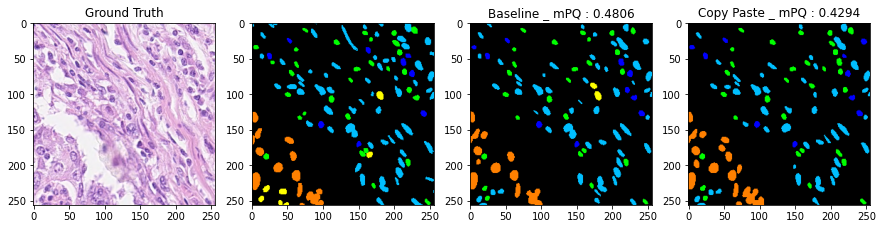

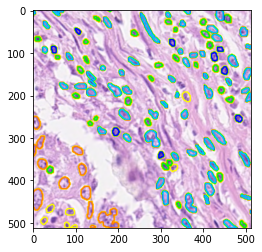

202


KeyboardInterrupt: 

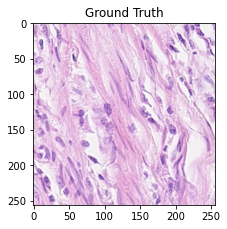

In [67]:
for i in range(1000):
    
    i+=200
    print(i+1)
    
    temp = test_dataset[i]
    image = temp['image']
    mask = temp['mask']
    
    #if (1 in np.unique(temp['mask'])) & (5 in np.unique(temp['mask'])):
    #    print(np.unique(temp['mask']))


    image = test_dataset[i]['image']
    mask_original = test_dataset[i]['mask'][0].numpy().astype('uint8')
    mask_baseline = pred_final_baseline[i][..., 1].astype('uint8')
    mask_copypaste = pred_final_copypaste[i][..., 1].astype('uint8')

    result_baseilne = compute_pq('seg_class', pred_final_baseline[i][None, ...], test_masks[i][None, ...])
    result_copypaste = compute_pq('seg_class', pred_final_copypaste[i][None, ...], test_masks[i][None, ...])
    mPQ_baseline = np.round(result_baseilne['multi_pq+'][0].mean(), 4)
    mPQ_copypaste = np.round(result_copypaste['multi_pq+'][0].mean(), 4)

    vis = {'0' : (0, 0, 0),
           '1' : (255,255,0),
           '2' : (255,128,0),
           '3' : (0, 255, 0),
           '4' : (0, 0, 255),
           '5' : (238, 0, 238),
           '6' : (0, 191, 255)}

    src_original = (image.permute(1, 2, 0).numpy()*255).astype('uint8').copy()
    src_baseline = (image.permute(1, 2, 0).numpy()*255).astype('uint8').copy()
    src_copypaste = (image.permute(1, 2, 0).numpy()*255).astype('uint8').copy()


    a = mask_original
    original_mask = np.zeros_like(a)[..., None].repeat(3, 2)
    for p in range(original_mask.shape[0]):
        for q in range(original_mask.shape[1]):
            original_mask[p, q, :] = vis['{}'.format(a[p, q])]    

    a = pred_final_baseline[i][..., 1].astype('uint8')
    baseline_mask = np.zeros_like(a)[..., None].repeat(3, 2)
    for p in range(baseline_mask.shape[0]):
        for q in range(baseline_mask.shape[1]):
            baseline_mask[p, q, :] = vis['{}'.format(a[p, q])]


    a = pred_final_copypaste[i][..., 1].astype('uint8')
    copypaste_mask = np.zeros_like(a)[..., None].repeat(3, 2)
    for p in range(copypaste_mask.shape[0]):
        for q in range(copypaste_mask.shape[1]):
            copypaste_mask[p, q, :] = vis['{}'.format(a[p, q])]


    plt.figure(figsize=(15, 15))

    plt.subplot(1, 4, 1)
    plt.imshow(src_original)
    plt.title("Ground Truth")

    plt.subplot(1, 4, 2)
    plt.imshow(original_mask)  

    plt.subplot(1, 4, 3)
    plt.imshow(baseline_mask)
    plt.title("Baseline _ mPQ : {}".format(mPQ_baseline))

    plt.subplot(1, 4, 4)
    plt.imshow(copypaste_mask)
    plt.title("Copy Paste _ mPQ : {}".format(mPQ_copypaste))

    plt.show()

    vis = {'0' : (0, 0, 0),
           '1' : (255,255,0),
           '2' : (255,128,0),
           '3' : (0, 255, 0),
           '4' : (0, 0, 255),
           '5' : (238, 0, 238),
           '6' : (0, 191, 255)}

    src_original = cv2.resize(src_original.copy(), None, fx=2, fy=2)
    mask_ = cv2.resize(mask.numpy().astype('uint8').copy()[0], None, fx=2, fy=2)

    src = src_original.copy()
    for c in np.unique(mask)[1:]:
        temp = (mask_ == c).astype('uint8')

        contours, hierarchy = cv2.findContours(temp, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

        for i in range(len(contours)):
            cv2.drawContours(src, [contours[i]], 0, vis['{}'.format(c)], 2)
            
    plt.imshow(src)
    plt.show()
    
    if i == 500:
        break

500
[0 1 2 3 4 5 6]


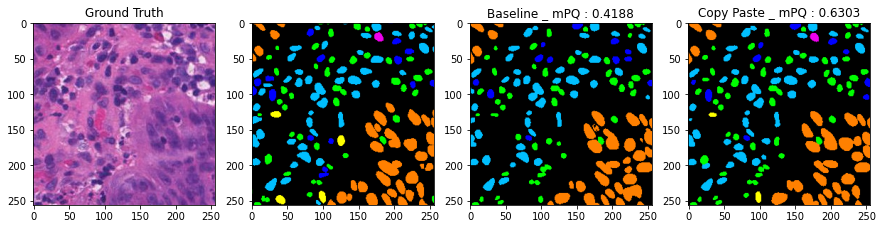

In [52]:
for i in range(100):
    
    i+=499
    print(i+1)
    
    temp = test_dataset[i]
    image = temp['image']
    mask = temp['mask']
    print(np.unique(temp['mask']))
    
  
    image = test_dataset[i]['image']
    mask_original = test_dataset[i]['mask'][0].numpy().astype('uint8')
    mask_baseline = pred_final_baseline[i][..., 1].astype('uint8')
    mask_copypaste = pred_final_copypaste[i][..., 1].astype('uint8')

    result_baseilne = compute_pq('seg_class', pred_final_baseline[i][None, ...], test_masks[i][None, ...])
    result_copypaste = compute_pq('seg_class', pred_final_copypaste[i][None, ...], test_masks[i][None, ...])
    mPQ_baseline = np.round(result_baseilne['multi_pq+'][0].mean(), 4)
    mPQ_copypaste = np.round(result_copypaste['multi_pq+'][0].mean(), 4)

    vis = {'0' : (0, 0, 0),
           '1' : (255,255,0),
           '2' : (255,128,0),
           '3' : (0, 255, 0),
           '4' : (0, 0, 255),
           '5' : (238, 0, 238),
           '6' : (0, 191, 255)}

    src_original = (image.permute(1, 2, 0).numpy()*255).astype('uint8').copy()
    src_baseline = (image.permute(1, 2, 0).numpy()*255).astype('uint8').copy()
    src_copypaste = (image.permute(1, 2, 0).numpy()*255).astype('uint8').copy()
    
    
    a = mask_original
    original_mask = np.zeros_like(a)[..., None].repeat(3, 2)
    for p in range(original_mask.shape[0]):
        for q in range(original_mask.shape[1]):
            original_mask[p, q, :] = vis['{}'.format(a[p, q])]    
    
    a = pred_final_baseline[i][..., 1].astype('uint8')
    baseline_mask = np.zeros_like(a)[..., None].repeat(3, 2)
    for p in range(baseline_mask.shape[0]):
        for q in range(baseline_mask.shape[1]):
            baseline_mask[p, q, :] = vis['{}'.format(a[p, q])]
    
   
    a = pred_final_copypaste[i][..., 1].astype('uint8')
    copypaste_mask = np.zeros_like(a)[..., None].repeat(3, 2)
    for p in range(copypaste_mask.shape[0]):
        for q in range(copypaste_mask.shape[1]):
            copypaste_mask[p, q, :] = vis['{}'.format(a[p, q])]
    
    
    plt.figure(figsize=(15, 15))
    
    plt.subplot(1, 4, 1)
    plt.imshow(src_original)
    plt.title("Ground Truth")
    
    plt.subplot(1, 4, 2)
    plt.imshow(original_mask)  
    
    plt.subplot(1, 4, 3)
    plt.imshow(baseline_mask)
    plt.title("Baseline _ mPQ : {}".format(mPQ_baseline))
    
    plt.subplot(1, 4, 4)
    plt.imshow(copypaste_mask)
    plt.title("Copy Paste _ mPQ : {}".format(mPQ_copypaste))
    
    plt.show() 
    
    break

In [53]:
cv2.imwrite('temp1.png', cv2.cvtColor(src_original, cv2.COLOR_BGR2RGB))
cv2.imwrite('temp2.png', cv2.cvtColor(original_mask, cv2.COLOR_BGR2RGB))
cv2.imwrite('temp3.png', cv2.cvtColor(baseline_mask, cv2.COLOR_BGR2RGB))
cv2.imwrite('temp4.png', cv2.cvtColor(copypaste_mask, cv2.COLOR_BGR2RGB))

True